# Stability and Runtime Analysis
This notebook evaluates the robustness of the XGBoost regressor on the rogue wave dataset by repeating the best-performing model across stratified folds and analysing the resulting error metrics and target distributions.

**Imports**

In [1]:
import time
import pandas as pd

from xgboost import XGBRegressor  
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

seed = 42

**Data Loading**

In [2]:
# Data file
file_data = '../data/abin_matrix_full_encoded.csv'

# Thresholds
threshold_upper_limit = 2.7
threshold_non_rogue_wave = 1.5
threshold_rogue_wave = 2.0

# Features and target
target = 'AI_10min'
target_cat = 'AI_10min_cat'
features = ['H_s', 'lambda_40', 'lambda_30', 'L_deep', 's', 'mu', 'kh', 'T_p','nu', 'Q_p', 'BFI', 'r', 'v_wind', 'v_gust', 'T_air', 'p', 'Delta_p_1h']

In [3]:
data_rogue_waves = pd.read_csv(file_data)

data_rogue_waves = data_rogue_waves.loc[data_rogue_waves.AI_10min < threshold_upper_limit]
data_rogue_waves = data_rogue_waves.loc[:,[target]+features]

data_rogue_waves_class = data_rogue_waves.copy()
data_rogue_waves_class[target_cat] = data_rogue_waves_class[target].apply(lambda x: 0 if x < threshold_non_rogue_wave else (1 if x < threshold_rogue_wave else 2))
data_rogue_waves_class[target_cat] = data_rogue_waves_class[target_cat].astype(int)

X = data_rogue_waves_class.drop(columns=["AI_10min", "AI_10min_cat"])
y = data_rogue_waves_class["AI_10min"]
y_cat = data_rogue_waves_class["AI_10min_cat"]

**Stability and Runtime Analysis**

In [4]:
hyperparameters_lm = {"alpha": 0.0001,	"l1_ratio": 0.1, "max_iter": 5000, "selection": "cyclic", "tol": 0.0001}
hyperparameters_rf = { "criterion": "friedman_mse", "max_depth": 30, "max_features": "sqrt", "max_samples": 0.5, "min_samples_leaf": 1, "n_estimators": 100}
hyperparameters_xgb = {"colsample_bytree": 0.8, "gamma": 0, "learning_rate": 0.1, "max_depth": 20, "min_child_weight": 1, "n_estimators": 100, "reg_alpha": 0, "reg_lambda": 1, "subsample": 0.5}

In [5]:
model_runtime = {"svm": [2477.463769197464, 2477.463769197464, 2477.463769197464, 2477.463769197464, 2477.463769197464, 2477.463769197464, 2477.463769197464, 2477.463769197464, 2477.463769197464, 2477.463769197464],
                  "elasticnet": [],
                  "random_forest": [],
                  "xgboost": [],
                  }

model_performance = {"svm": [0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95], 
                    "elasticnet": [],
                    "random_forest": [],
                    "xgboost": [],
                    }

targets_train = {}
targets_test = {}

In [6]:
skf = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

In [7]:
for j in range(2):
    for i, (train_index, test_index) in enumerate(skf.split(X, y_cat)):
        fold = i+1

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        X_train, X_test = X_train.reset_index(drop=True), X_test.reset_index(drop=True)
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        y_train, y_test = y_train.reset_index(drop=True), y_test.reset_index(drop=True)

        targets_train[f"Distribution for train set target of fold {fold}"] = y_train
        targets_test[f"Distribution for test set target of fold {fold}"] = y_test

        scaler = StandardScaler()
        X_train_transformed = scaler.fit_transform(X_train)
        X_test_transformed = scaler.transform(X_test)

        start = time.time()
        model = ElasticNet(random_state=seed, **hyperparameters_lm)

        model.fit(X_train_transformed, y_train)
        end = time.time()
        model_runtime["elasticnet"].append(end - start)

        y_pred = model.predict(X_test_transformed)
        y_true = y_test
        model_performance["elasticnet"].append(r2_score(y_true, y_pred))

        time.sleep(10)   


        start = time.time()
        model = RandomForestRegressor(random_state=seed, **hyperparameters_rf)

        model.fit(X_train, y_train)
        end = time.time()
        model_runtime["random_forest"].append(end - start)

        y_pred = model.predict(X_test)
        y_true = y_test
        model_performance["random_forest"].append(r2_score(y_true, y_pred))

        time.sleep(10)


        start = time.time()
        model = XGBRegressor(random_state=seed, **hyperparameters_xgb)

        model.fit(X_train, y_train)
        end = time.time()
        model_runtime["xgboost"].append(end - start)

        y_pred = model.predict(X_test)
        y_true = y_test
        model_performance["xgboost"].append(r2_score(y_true, y_pred))

        time.sleep(10)

targets_train = pd.DataFrame(targets_train)
targets_test = pd.DataFrame(targets_test)

df_model_runtime = pd.DataFrame(model_runtime)
df_model_runtime = df_model_runtime.melt(
    var_name="Model",
    value_name="Runtime"
)

df_model_performance = pd.DataFrame(model_performance)
df_model_performance = df_model_performance.melt(
    var_name="Model",
    value_name="R2"
)


**Plot Results**

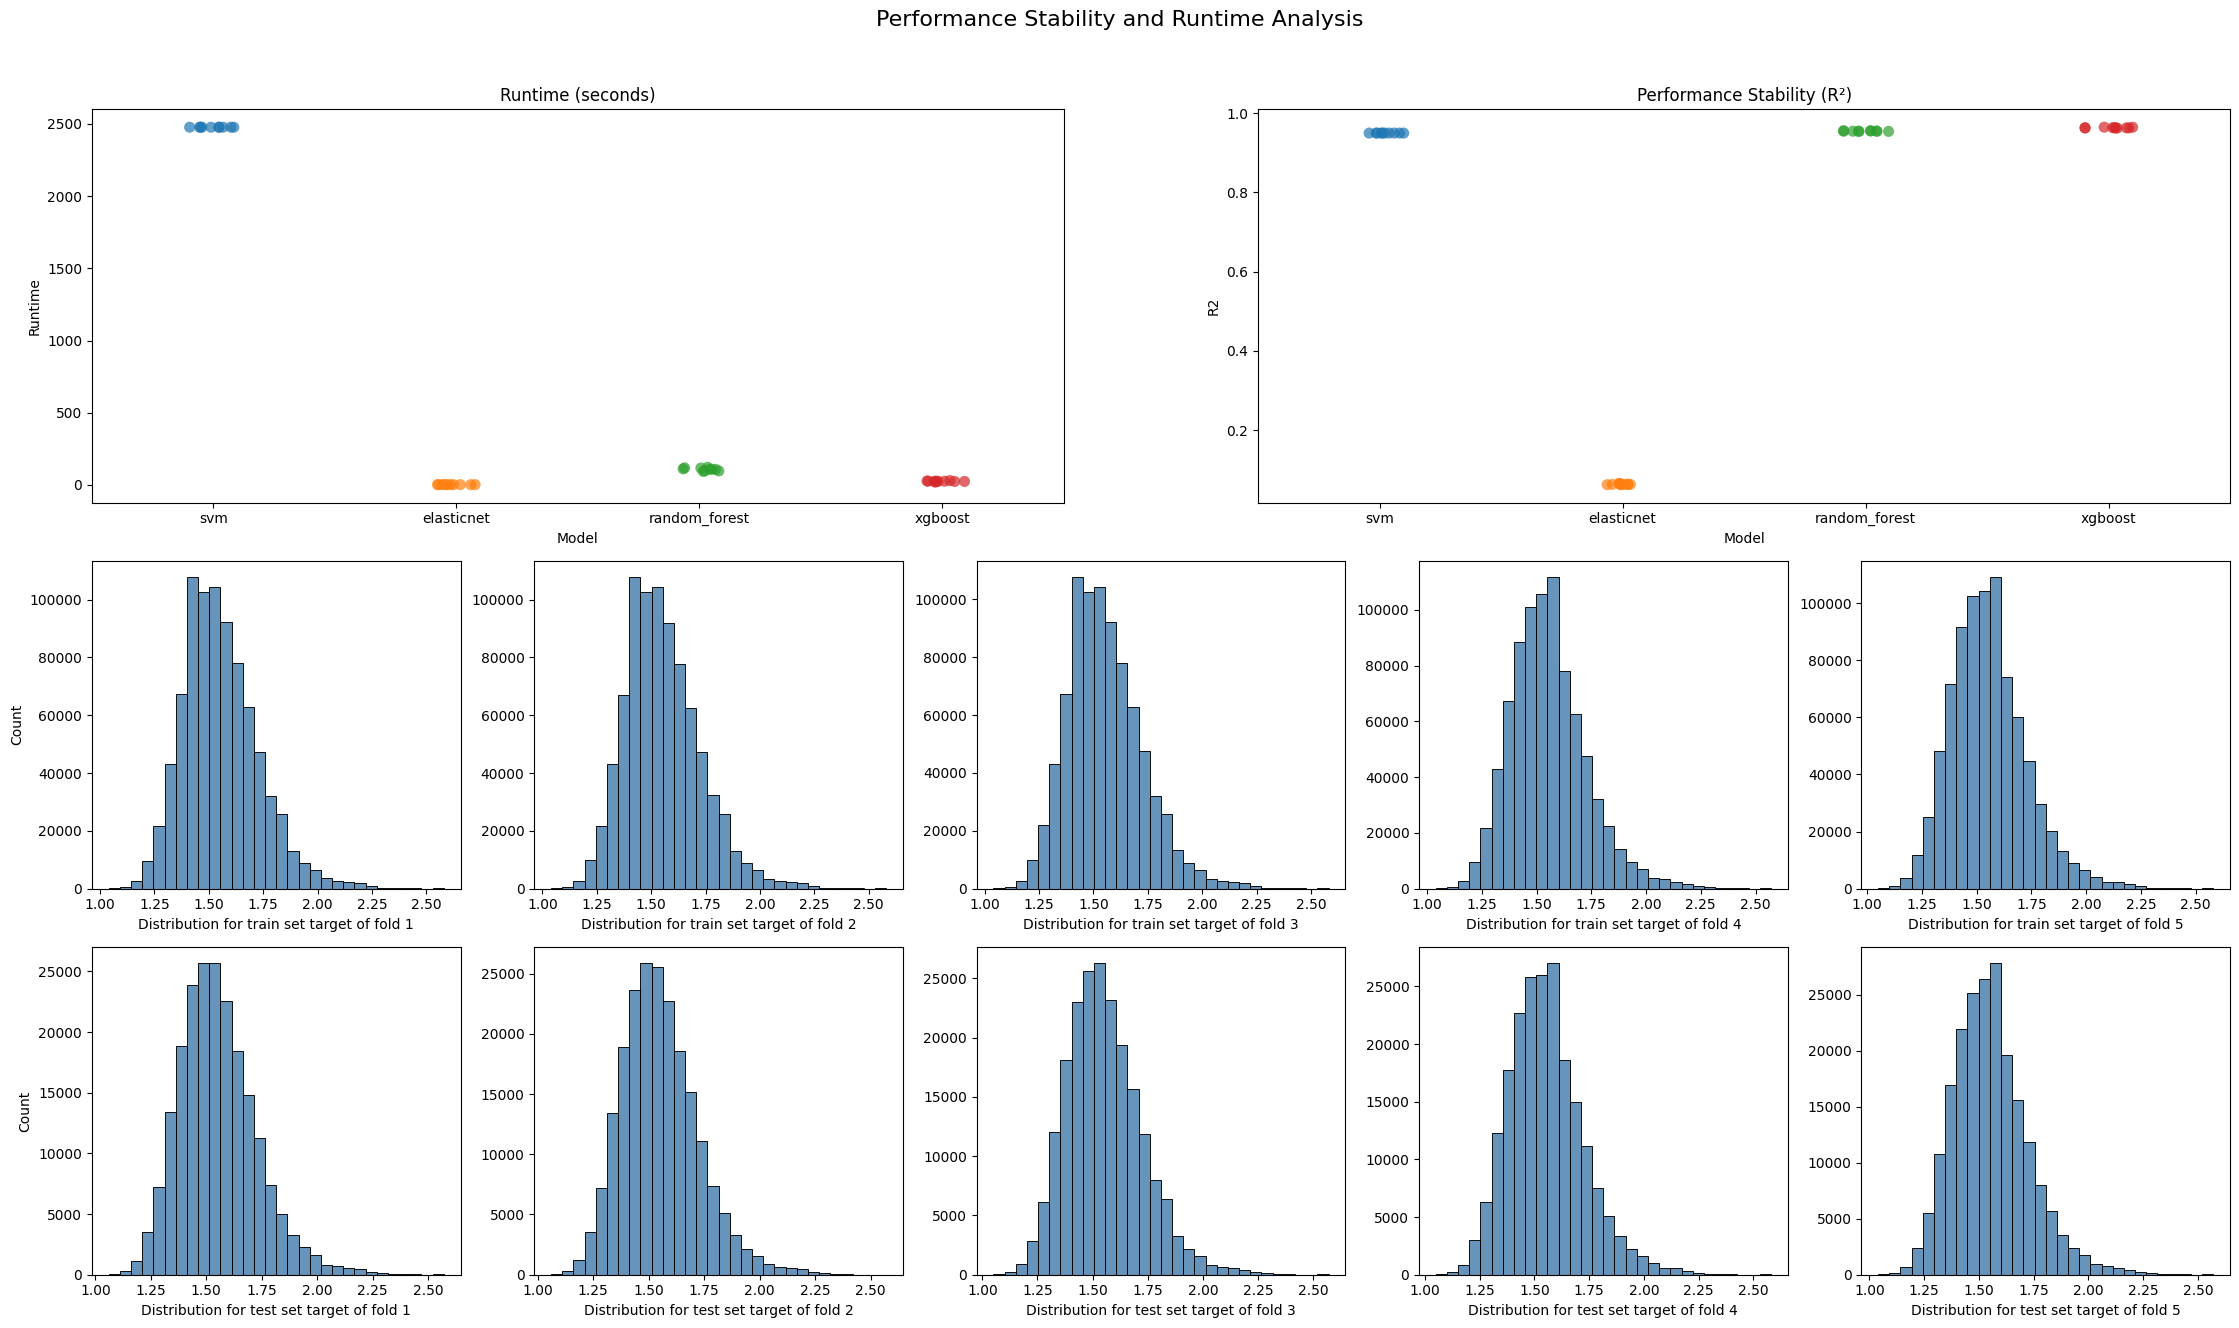

In [11]:
num_cols = targets_train.shape[1]

# Main figure
fig = plt.figure(figsize=(num_cols * 4.5, 4.5 * 3))
fig.suptitle("Performance Stability and Runtime Analysis", fontsize=16, y=0.98)

# Outer GridSpec: 3 rows (train, test, bottom-row)
outer = gridspec.GridSpec(
    3, 1, 
    height_ratios=[1.2, 1, 1], 
    figure=fig
)

# Inner GridSpec: performance Stability and Runtime
gs_bottom = gridspec.GridSpecFromSubplotSpec(
    1, 2,                   # Exactly 2 equal-sized columns
    subplot_spec=outer[0],
    wspace=0.2
)

# Left plot: Runtime
ax_runtime = fig.add_subplot(gs_bottom[0, 0])
sns.stripplot(
    data=df_model_runtime,
    x="Model",
    y="Runtime",
    hue="Model",
    jitter=True,
    size=8,
    alpha=0.7,
    ax=ax_runtime,
)
ax_runtime.set_title("Runtime (seconds)")

# Right plot: Performance
ax_perf = fig.add_subplot(gs_bottom[0, 1])
sns.stripplot(
    data=df_model_performance,
    x="Model",
    y="R2",
    hue="Model",
    jitter=True,
    size=8,
    alpha=0.7,
    ax=ax_perf,
)
ax_perf.set_title("Performance Stability (R²)")

# Inner GridSpec: Training Target Distribution
gs_train = gridspec.GridSpecFromSubplotSpec(
    1, num_cols, subplot_spec=outer[1]
)

for n, feature in enumerate(targets_train.columns):
    ax = fig.add_subplot(gs_train[0, n])
    sns.histplot(
        data=targets_train,
        x=feature,
        bins=30,
        ax=ax,
        color="#3470a3"
    )
    if n > 0:
        ax.set_ylabel("") 


# Inner GridSpec: Test Target Distribution
gs_test = gridspec.GridSpecFromSubplotSpec(
    1, num_cols, subplot_spec=outer[2]
)

for n, feature in enumerate(targets_test.columns):
    ax = fig.add_subplot(gs_test[0, n])
    sns.histplot(
        data=targets_test,
        x=feature,
        bins=30,
        ax=ax,
        color="#3470a3"
    )
    if n > 0:
        ax.set_ylabel("") 

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
